In [1]:
import random
import gym
import math
import numpy as np
import tensorflow as tf
from collections import deque

# Use if running on a GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

C:\Users\Zenaardvark\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Problem 4: SARSA Q-Learning (30 points)
    
SARSA is an alternative way of learning a Q-Value function with a lot of similarity to the simpler
policy introduced during the code exercises.

    (a) Implement a deep Q-learning approach to the cart pole problem (was done in class)
    using an �-Greedy approach

In [5]:
class DQNCartPoleSolver_Q():
    def __init__(self, n_episodes=1000, n_win_ticks=195, max_env_steps=None, gamma=1.0, epsilon=1.0, epsilon_min=0.01, epsilon_log_decay=0.995, alpha=0.01, alpha_decay=0.01, batch_size=64, monitor=False, quiet=False):
        self.memory = deque(maxlen=100000)
        self.env = gym.make('CartPole-v0')
        #if monitor: self.env = gym.wrappers.Monitor(self.env, '../data/cartpole-1', force=True)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.n_episodes = n_episodes
        self.n_win_ticks = n_win_ticks
        self.batch_size = batch_size
        self.quiet = quiet
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps

        # Init model
        self.state_ = tf.placeholder(tf.float32, shape=[None, 4])
        h = tf.layers.dense(self.state_, units=24, activation=tf.nn.tanh)
        h = tf.layers.dense(h, units=48, activation=tf.nn.tanh)
        self.Q = tf.layers.dense(h, units=2)
        
        self.Q_ = tf.placeholder(tf.float32, shape=[None, 2])
        loss = tf.losses.mean_squared_error(self.Q_, self.Q)
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        lr = tf.train.exponential_decay(0.01, self.global_step, 0.995, 1)
        self.train_step = tf.train.AdamOptimizer(lr).minimize(loss, global_step=self.global_step)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.sess.run(self.Q, feed_dict={self.state_: state}))

    def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((t + 1) * self.epsilon_decay)))

    def preprocess_state(self, state):
        return np.reshape(state, [1, 4])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(
            self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = self.sess.run(self.Q, feed_dict={self.state_: state})
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.sess.run(self.Q, feed_dict={self.state_: next_state})[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        self.sess.run(self.train_step, feed_dict={self.state_: np.array(x_batch), self.Q_: np.array(y_batch)})

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def __del__(self):
        self.env.close()
        
    def run(self):
        scores = deque(maxlen=100)

        for e in range(self.n_episodes):
            state = self.preprocess_state(self.env.reset())
            done = False
            i = 0
            while not done:
                if e % 100 == 0 and not self.quiet:
                    self.env.render()
                action = self.choose_action(state, self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1

            scores.append(i)
            mean_score = np.mean(scores)
            if mean_score >= self.n_win_ticks and e >= 100:
                if not self.quiet: print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return e - 100
            if e % 100 == 0 and not self.quiet:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))

            self.replay(self.batch_size)
        
        if not self.quiet: print('Did not solve after {} episodes 😞'.format(e))
        self.env.close()
        return e

In [6]:
agent = DQNCartPoleSolver_Q()
agent.run()
del agent

[Episode 0] - Mean survival time over last 100 episodes was 15.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 16.85 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 33.62 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 81.67 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 111.88 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 129.2 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 124.85 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 123.8 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 162.28 ticks.
Ran 830 episodes. Solved after 730 trials ✔


    (b) Implement a SARSA approach with a deep network to solve the cart pole problem using
    an e-Greedy approach

In [7]:
class DQNCartPoleSolver_SARSA():
    def __init__(self, n_episodes=1000, n_win_ticks=195, max_env_steps=None, gamma=1.0, epsilon=1.0, epsilon_min=0.01, epsilon_log_decay=0.995, alpha=0.01, alpha_decay=0.01, batch_size=64, monitor=False, quiet=False):
        self.memory = deque(maxlen=100000)
        self.env = gym.make('CartPole-v0')
        #if monitor: self.env = gym.wrappers.Monitor(self.env, '../data/cartpole-1', force=True)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.n_episodes = n_episodes
        self.n_win_ticks = n_win_ticks
        self.batch_size = batch_size
        self.quiet = quiet
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps

        # Init model
        self.state_ = tf.placeholder(tf.float32, shape=[None, 4])
        h = tf.layers.dense(self.state_, units=24, activation=tf.nn.tanh)
        h = tf.layers.dense(h, units=48, activation=tf.nn.tanh)
        self.Q = tf.layers.dense(h, units=2)
        
        self.Q_ = tf.placeholder(tf.float32, shape=[None, 2])
        loss = tf.losses.mean_squared_error(self.Q_, self.Q)
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        lr = tf.train.exponential_decay(0.01, self.global_step, 0.995, 1)
        self.train_step = tf.train.AdamOptimizer(lr).minimize(loss, global_step=self.global_step)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.sess.run(self.Q, feed_dict={self.state_: state}))

    def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((t + 1) * self.epsilon_decay)))

    def preprocess_state(self, state):
        return np.reshape(state, [1, 4])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(
            self.memory, min(len(self.memory), batch_size))
        for counter, [state, action, reward, next_state, done] in enumerate(minibatch):
            if counter+1 < len(minibatch):
                y_target = self.sess.run(self.Q, feed_dict={self.state_: state})
                next_action = minibatch[counter+1][1]
                #print(self.sess.run(self.Q, feed_dict={self.state_: next_state}))
                y_target[0][action] = reward if done else reward + self.gamma * self.sess.run(self.Q, feed_dict={self.state_: next_state})[0][next_action]
                x_batch.append(state[0])
                y_batch.append(y_target[0])
        
        self.sess.run(self.train_step, feed_dict={self.state_: np.array(x_batch), self.Q_: np.array(y_batch)})

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def __del__(self):
        self.env.env.close()
        self.env.close()
        
    def run(self):
        scores = deque(maxlen=100)

        for e in range(self.n_episodes):
            state = self.preprocess_state(self.env.reset())
            done = False
            i = 0
            while not done:
                if e % 100 == 0 and not self.quiet:
                    self.env.render()
                action = self.choose_action(state, self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1

            scores.append(i)
            mean_score = np.mean(scores)
            if mean_score >= self.n_win_ticks and e >= 100:
                if not self.quiet: print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return e - 100
            if e % 100 == 0 and not self.quiet:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))

            self.replay(self.batch_size)
        
        if not self.quiet: print('Did not solve after {} episodes 😞'.format(e))
        self.env.close()
        return e

In [8]:
agent = DQNCartPoleSolver_SARSA()
agent.run()
del agent

[Episode 0] - Mean survival time over last 100 episodes was 17.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 32.37 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 54.28 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 183.8 ticks.
Ran 364 episodes. Solved after 264 trials ✔


    (c) Evaluate the impact of gamma in the cart pole problem. How important is this parameter?
    How does it affect stability and learning?

In [3]:
#For graph
import matplotlib.pyplot as plt

In [5]:
#Let's just iterate over a few different values of gamma and see how many trials it takes each of them
#Let's test gamma on the SARSA solver as the results seem a little better

gammas = [1.,0.99,0.9,0.5,0.1,0]
gamma_eps = []
trials = 3

for curr_gamma in gammas:
    
    curr_vals = []
    
    for _ in range(trials):
        curr_agent = DQNCartPoleSolver_SARSA(gamma = curr_gamma)
        curr_vals.append(curr_agent.run())
        del curr_agent
        print("... with gamma of {}".format(curr_gamma))

    gamma_eps.append(np.mean(curr_vals))

[Episode 0] - Mean survival time over last 100 episodes was 11.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 18.48 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 73.72 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 172.21 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 143.0 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 167.83 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 184.4 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 187.27 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 188.3 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 190.89 ticks.
Ran 981 episodes. Solved after 881 trials ✔
... with gamma of 1.0
[Episode 0] - Mean survival time over last 100 episodes was 12.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 14.74 ticks.
[Episode 200] - Mean survival time o

[Episode 600] - Mean survival time over last 100 episodes was 25.41 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 32.99 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 20.81 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 19.27 ticks.
Did not solve after 999 episodes 😞
... with gamma of 0.1
[Episode 0] - Mean survival time over last 100 episodes was 19.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 12.81 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 9.62 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 9.54 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 9.54 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 9.64 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 9.7 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 9.6 ticks.
[Episode 800] - Mean survival time over last 100 episo

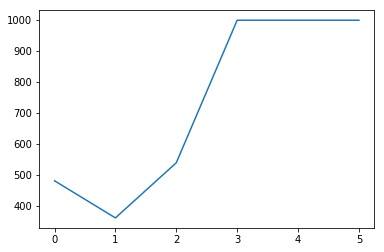

In [6]:
#Let's show the results over our range of gammas
plt.plot(gamma_eps)
plt.show()

Above is a graph which shows the trial count average over three tests for a range of epsilon values [1.,0.99,0.9,0.5,0.1,0]. Gamma values seem best at around 0.99, and anything 0.5 and below is just non-functional.  A gamma of 0.99 is also the most consistent completign at around 500 iterations per trial.  Gamma values are best chosen in this case at above 0.9.

    (d) Evaluate the impact of epsilon on the learning over the feasible range (0-1). What values
    seem reasonable?

In [7]:
epsilons = [1.,0.99,0.9,0.5,0.1,0]
epsilon_eps = []

for curr_epsilon in epsilons:
    
    curr_vals = []
    
    for _ in range(trials):
        curr_agent = DQNCartPoleSolver_SARSA(epsilon = curr_epsilon)
        curr_vals.append(curr_agent.run())
        del curr_agent
        print("... with gamma of {}".format(curr_epsilon))
        
    epsilon_eps.append(np.mean(curr_vals))

[Episode 0] - Mean survival time over last 100 episodes was 13.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 53.77 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 69.01 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 193.29 ticks.
Ran 320 episodes. Solved after 220 trials ✔
... with gamma of 0
[Episode 0] - Mean survival time over last 100 episodes was 44.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 42.83 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 101.48 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 160.57 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 168.08 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 144.78 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 134.87 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 164.46 ticks.
[Episode 800] - Mean survival time 

[Episode 400] - Mean survival time over last 100 episodes was 190.13 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 154.31 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 194.01 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 194.38 ticks.
Ran 727 episodes. Solved after 627 trials ✔
... with gamma of 0
[Episode 0] - Mean survival time over last 100 episodes was 21.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 45.88 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 109.68 ticks.
Ran 258 episodes. Solved after 158 trials ✔
... with gamma of 0
[Episode 0] - Mean survival time over last 100 episodes was 9.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 18.29 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 58.24 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 39.12 ticks.
[Episode 400] - Mean survival time over last 100 

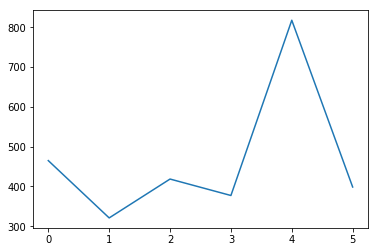

In [8]:
#Let's show the results over our range of gammas
plt.plot(epsilon_eps)
plt.show()

Above is a graph which shows the trial count average over three tests for a range of epsilon values [1.,0.99,0.9,0.5,0.1,0].  We can see that epsilon values around 0.99 are the best, though trials aren't conclusive due to their inconsistency.  It seems best to select an epsilon value that around 0.5 or above.

    (e) Pick one other small agent from the OpenAI gym and apply the same techniques 

In [8]:
class MountCarSolver_SARSA():
    def __init__(self, n_episodes=1000, max_env_steps=250, gamma=0.95, epsilon=0.95, epsilon_min=0.01, epsilon_log_decay=0.995, alpha=0.5, alpha_decay=0.01, batch_size=64, monitor=False, quiet=False):
        self.memory = deque(maxlen=100000)
        self.env = gym.make('MountainCar-v0')
        
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.quiet = quiet
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps

        # Init model
        self.state_ = tf.placeholder(tf.float32, shape=[None, 2])
        h = tf.layers.dense(self.state_, units=96, activation=tf.nn.relu)
        h = tf.layers.dense(h, units=96, activation=tf.nn.relu)
        self.Q = tf.layers.dense(h, units=3)
        
        self.Q_ = tf.placeholder(tf.float32, shape=[None, 3])
        loss = tf.losses.mean_squared_error(self.Q_, self.Q)
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        lr = tf.train.exponential_decay(0.005, self.global_step, 0.995, 1)
        self.train_step = tf.train.AdamOptimizer(lr).minimize(loss, global_step=self.global_step)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.sess.run(self.Q, feed_dict={self.state_: state}))

    def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((t + 1) * self.epsilon_decay)))

    def preprocess_state(self, state):
        return np.reshape(state, [1, 2])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(
            self.memory, min(len(self.memory), batch_size))
        for counter, [state, action, reward, next_state, done] in enumerate(minibatch):
            if counter+1 < len(minibatch):
                y_target = self.sess.run(self.Q, feed_dict={self.state_: state})
                next_action = minibatch[counter+1][1]
                #print(self.sess.run(self.Q, feed_dict={self.state_: next_state}))
                y_target[0][action] = reward if done else reward + self.gamma * np.max(self.sess.run(self.Q, feed_dict={self.state_: next_state})[0])
                x_batch.append(state[0])
                y_batch.append(y_target[0])
        
        self.sess.run(self.train_step, feed_dict={self.state_: np.array(x_batch), self.Q_: np.array(y_batch)})

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def __del__(self):
        self.env.env.close()
        self.env.close()
        
    def run(self):
        scores = deque(maxlen=5)
        reward_counter = deque(maxlen=50)
        
        for e in range(self.n_episodes):
            
            #Stored values for reward
            min_pos = 0.6
            max_pos = -1.2
            max_vel = 0
            reward_count = 0
            
            state = self.preprocess_state(self.env.reset())
            done = False
            while not done:
                if e % 50 == 0 and not self.quiet:
                    self.env.render()
                action = self.choose_action(state, self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                
                #Alter reward to convince the vehicle to try and reach maximum state
                if next_state[0] >= 0.5:
                    reward = 2
                else:
                    curr_pos = next_state[0]
                    if curr_pos > max_pos:
                        max_pos = curr_pos
                        reward = 1
                    elif curr_pos < min_pos:
                        min_pos = curr_pos
                        reward = 0.5
                    curr_vel = abs(next_state[1])
                    if curr_vel > max_vel:
                        max_vel = curr_vel
                        reward = 0.5
                if reward > 0:
                    reward_count += reward
                
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                
            scores.append(reward)    
            reward_counter.append(reward_count)   
            mean_score = np.mean(scores)
            if mean_score == 2 and e >= 5:
                self.env.render()
                if not self.quiet: print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 5))
                return e - 5
            if e % 50 == 0 and not self.quiet:
                print('[Episode {}] - Average count of rewards is {}.'.format(e, np.mean(reward_counter)))

            self.replay(self.batch_size)
        
        if not self.quiet: print('Did not solve after {} episodes 😞'.format(e))
        self.env.close()
        return e

In [9]:
agent = MountCarSolver_SARSA()
agent.run()
del agent

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[Episode 0] - Average count of rewards is 66.0.
[Episode 50] - Average count of rewards is 54.65.
[Episode 100] - Average count of rewards is 61.41.
[Episode 150] - Average count of rewards is 50.91.
[Episode 200] - Average count of rewards is 55.83.
[Episode 250] - Average count of rewards is 57.15.
[Episode 300] - Average count of rewards is 55.66.
[Episode 350] - Average count of rewards is 50.74.
[Episode 400] - Average count of rewards is 53.85.
[Episode 450] - Average count of rewards is 56.15.
[Episode 500] - Average count of rewards is 55.34.
[Episode 550] - Average count of rewards is 48.28.
[Episode 600] - Average count of rewards is 62.95.
[Episode 650] - Average count of rewards is 57.05.
[Episode 700] - Average count of rewards is 61.25.
[Episode 750] - Average count of rewards is 55.09.
[Episode 800] - Average count of rewards is 55.57.
[Episode 850] - Average count of rewar

Completes about 50% of the time.  Can complete at iteration 300 or close to the end.  Completion is defined as reaching the goal 5 times in a row.